<h1>Provenance Tracking with Attack Graphs<br>using SysFlow
</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<h3><strong>AvengerCon 2022</strong></h3>
<br>
<br>
<br>


<h4 style="color:gray">IBM Research</h4>

## Agenda

### Part 1: SysFlow overview

### Part 2: Provenace tracking with SysFlow

### Part 3: Attack reconstruction leveraging provenance graphs

# Part 1: SysFlow Overview


In [ ]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install sysflow-tools==0.5.1rc2

# install colab-xterm for interactive terminal
!pip install colab-xterm
%load_ext colabxterm

# install jq cli
!apt-get install jq

In [ ]:
import numpy as np
import pandas as pd
from sysflow.graphlet import Graphlet
from sysflow.formatter import SFFormatter
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'res', 'flow.rbytes', 'flow.rops', 'flow.wbytes', 'flow.wops', 'container.id', 'tags']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']

<h2>SysFlow</h2>
<center>
<img style="margin:0px; padding:50px;" src="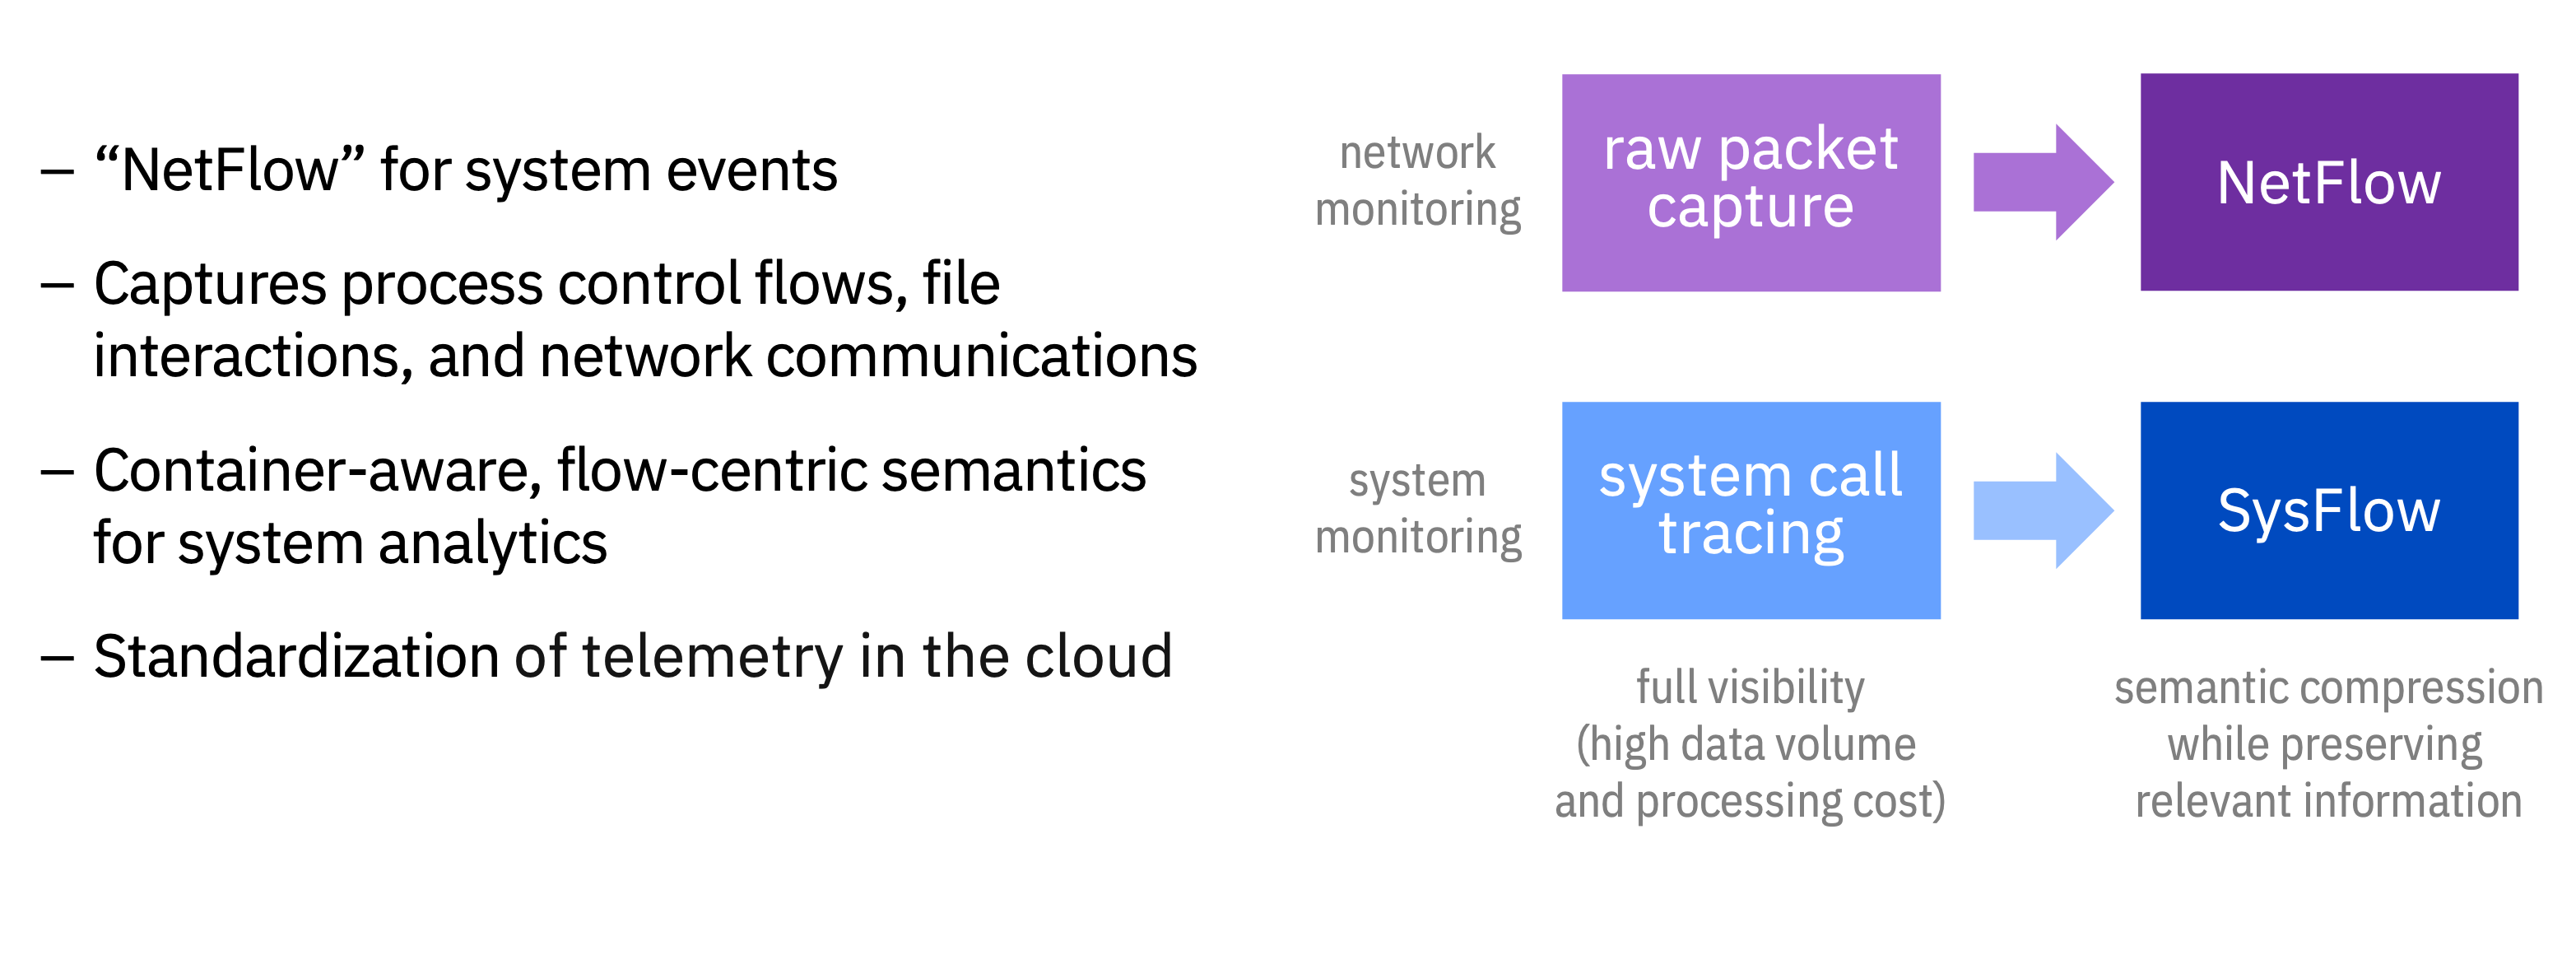
"/>
</center>

<h2>A SysFlow trace is a <i>provenance graph</i></h2>
<br><br>
<center>
    <img style="margin:0px; padding:50px;" src="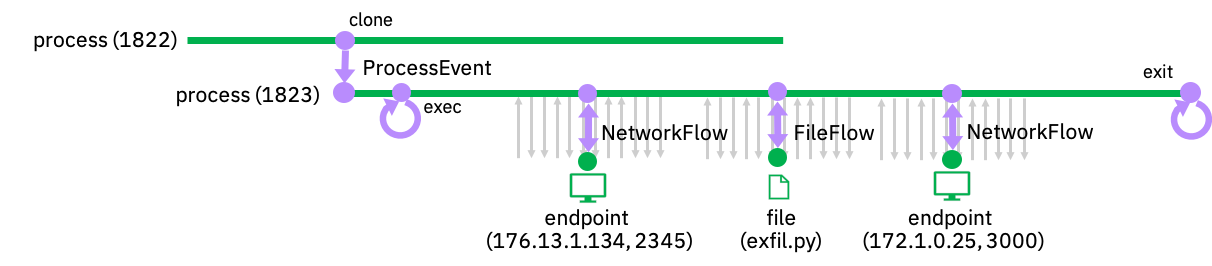
"/>
</center>

<br><br>

<h2>The underlying <i>format</i> is entity-relational
<center>
    <img style="margin:0px; padding:50px;" src="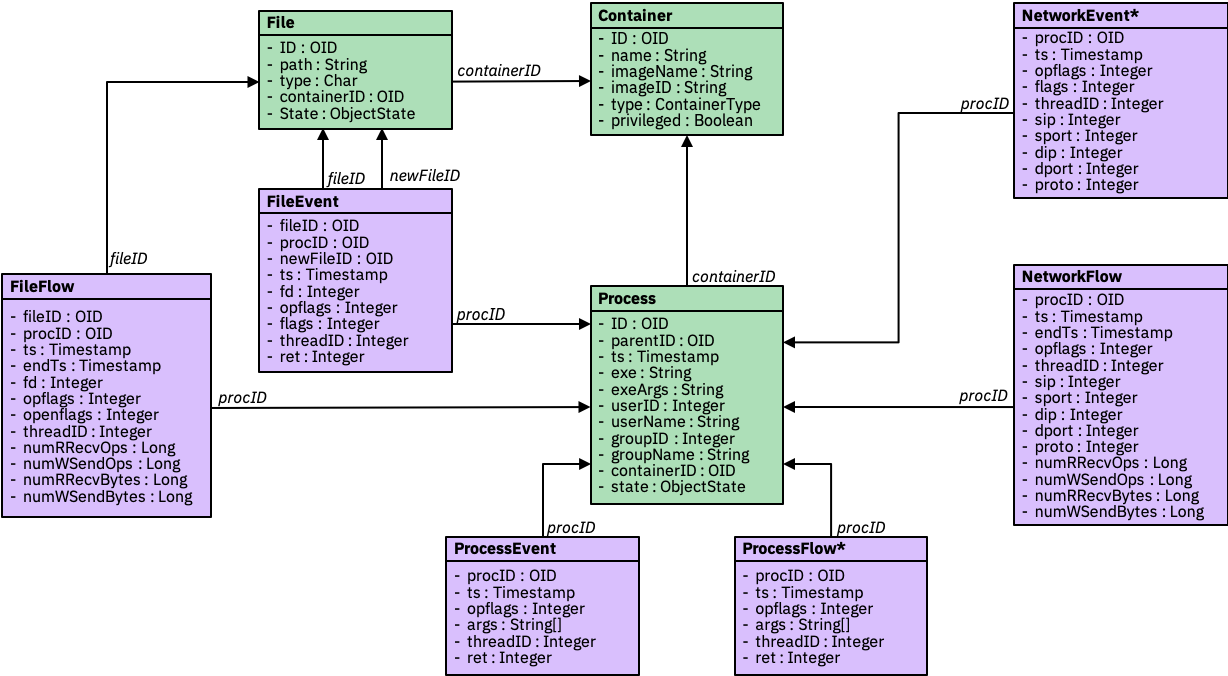
"/>
</center>

<h2>SysFlow agent architecture</h2>
<center>
    <img style="margin:0px; padding:50px;" src="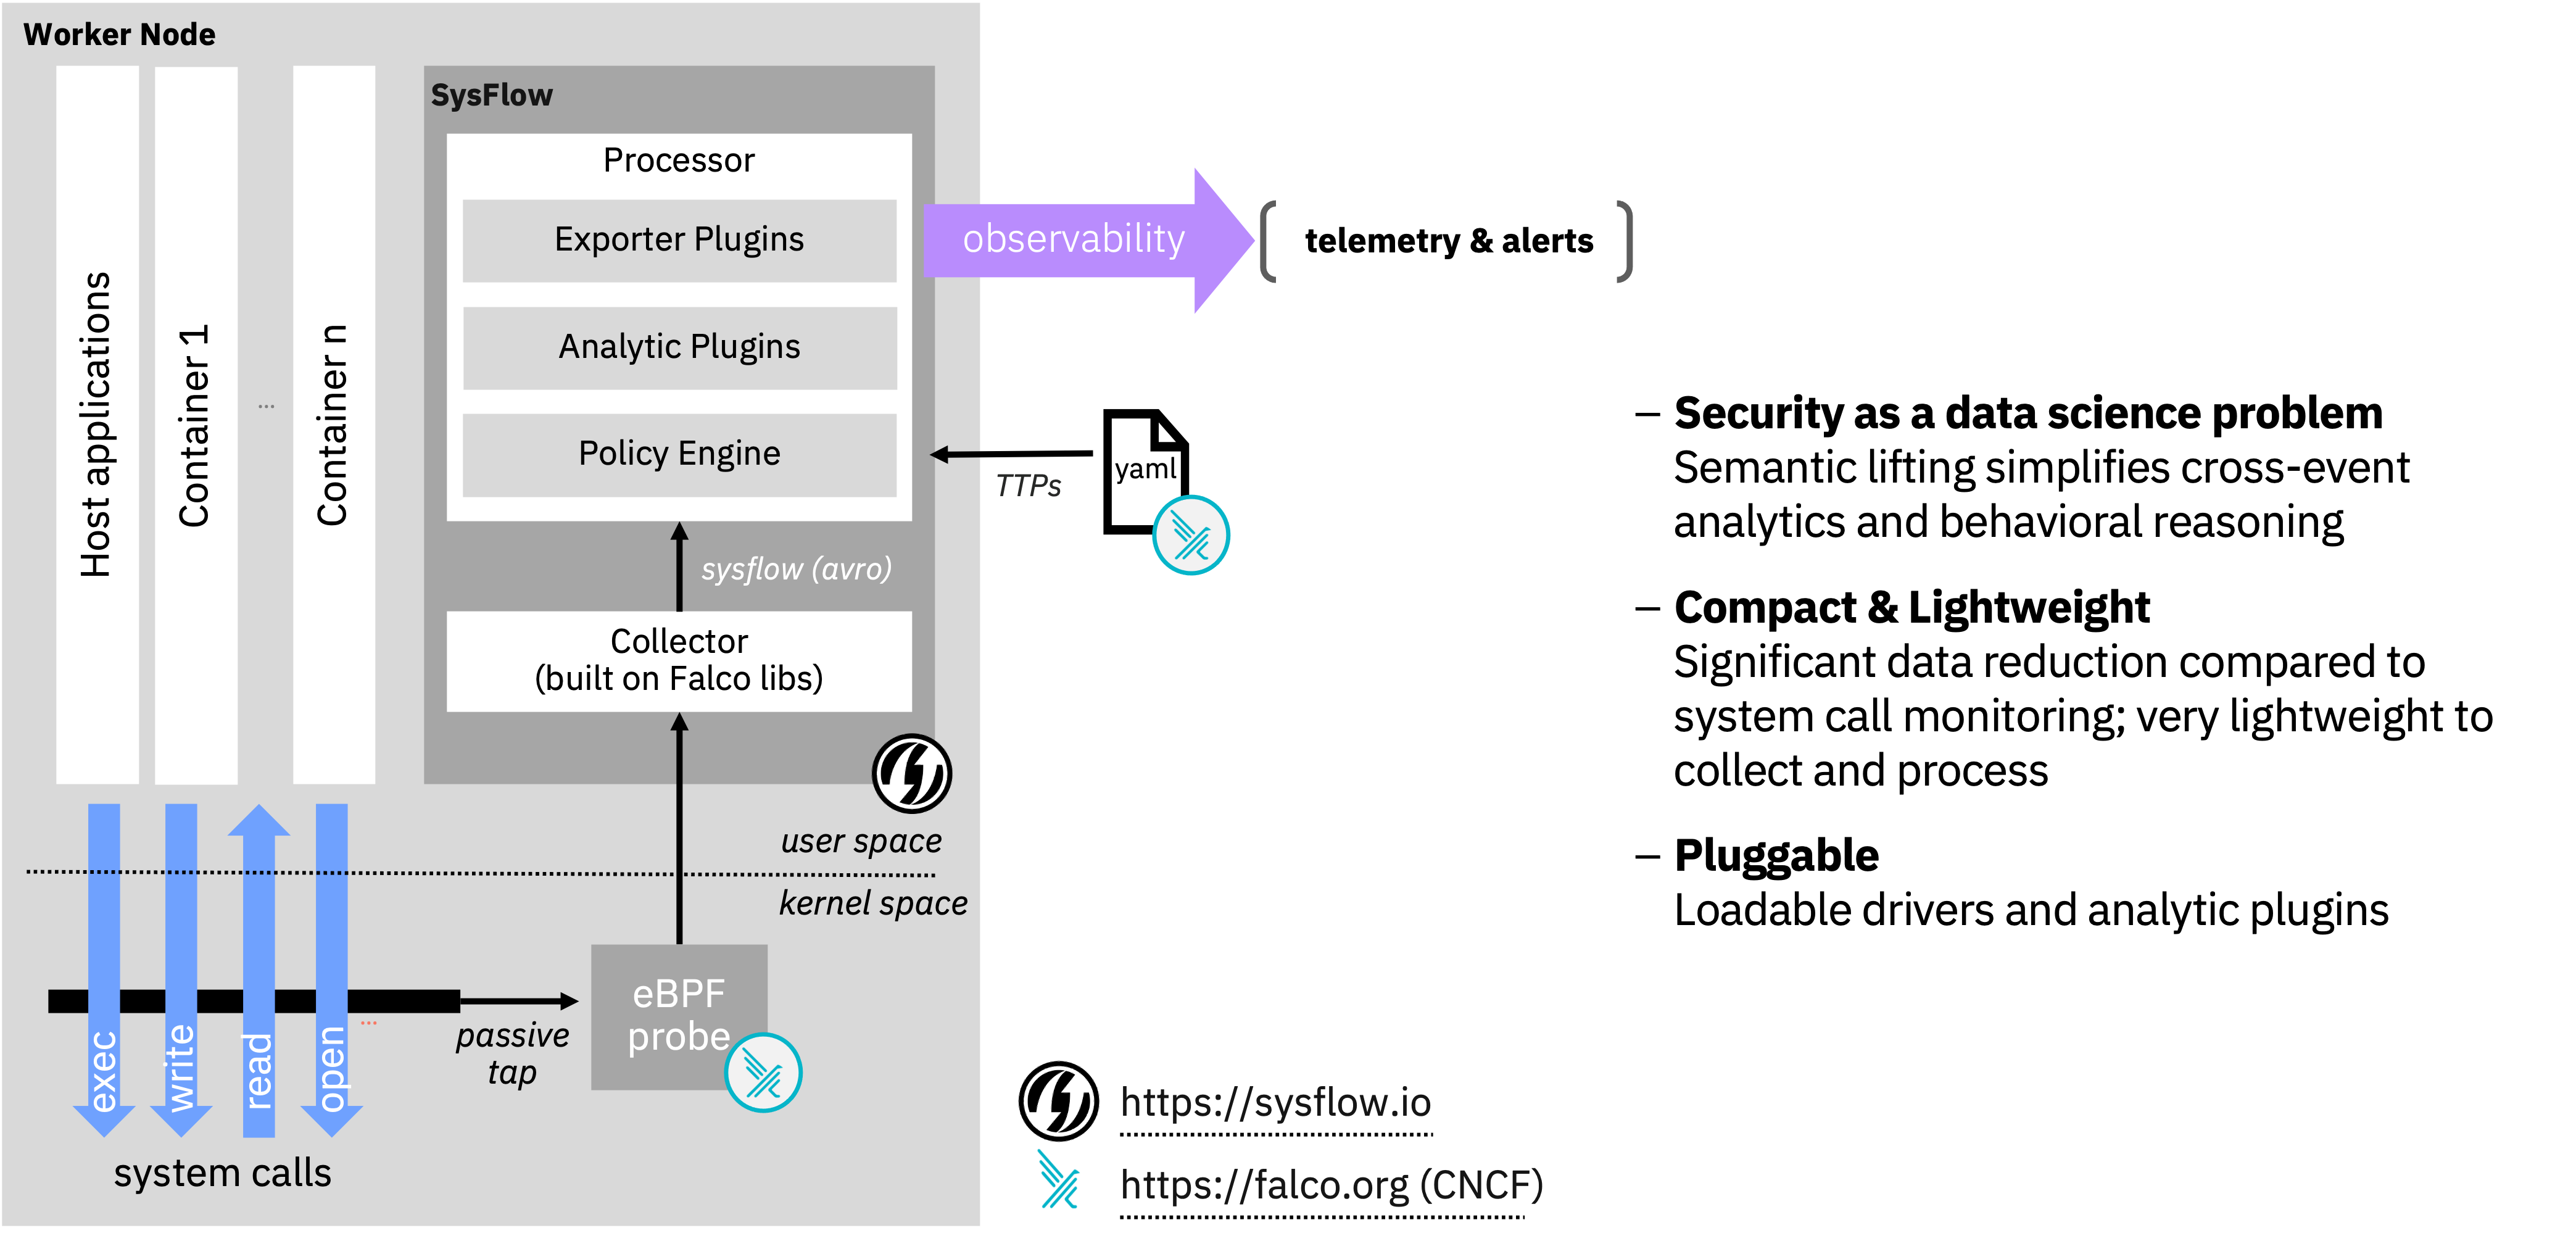
"/>
</center>

<h2>Hands on: interactive trace inspection</h2>

<br>

Try the following example commands in the interative shell: 

```
# to inspect a trace
sysprint data/samples/tcp.sf

# to filter output
sysprint -f "proc.name=server" data/samples/tcp.sf

# to list available fields
sysprint -l

# to display output in JSON
sysprint -o json data/samples/tcp.sf | jq .
sysprint -o json data/samples/tcp.sf | jq '.proc.pid' | sort | uniq

# for command line usage and help
sysprint -h
```

In [ ]:
%xterm

# Part 2: Provenace Tracking with SysFlow


## SysFlow _graphlet_


- Provide context around individual events
- Coalesce process events, file flows, and network flows based on control flow path
- Labeled direct graph ([API](https://sysflow.readthedocs.io/en/dev/python-api.html#module-sysflow.graphlet))
  - Events are labeled edges that associate two process nodes inhabited by their corresponding process instances
  - Flows associate a process node to file and network flow nodes that summarize filesystem and network activity

<h2>Data abstraction and analytics pipeline</h2>
<center>
    <img style="margin:0px; padding:50px;" src="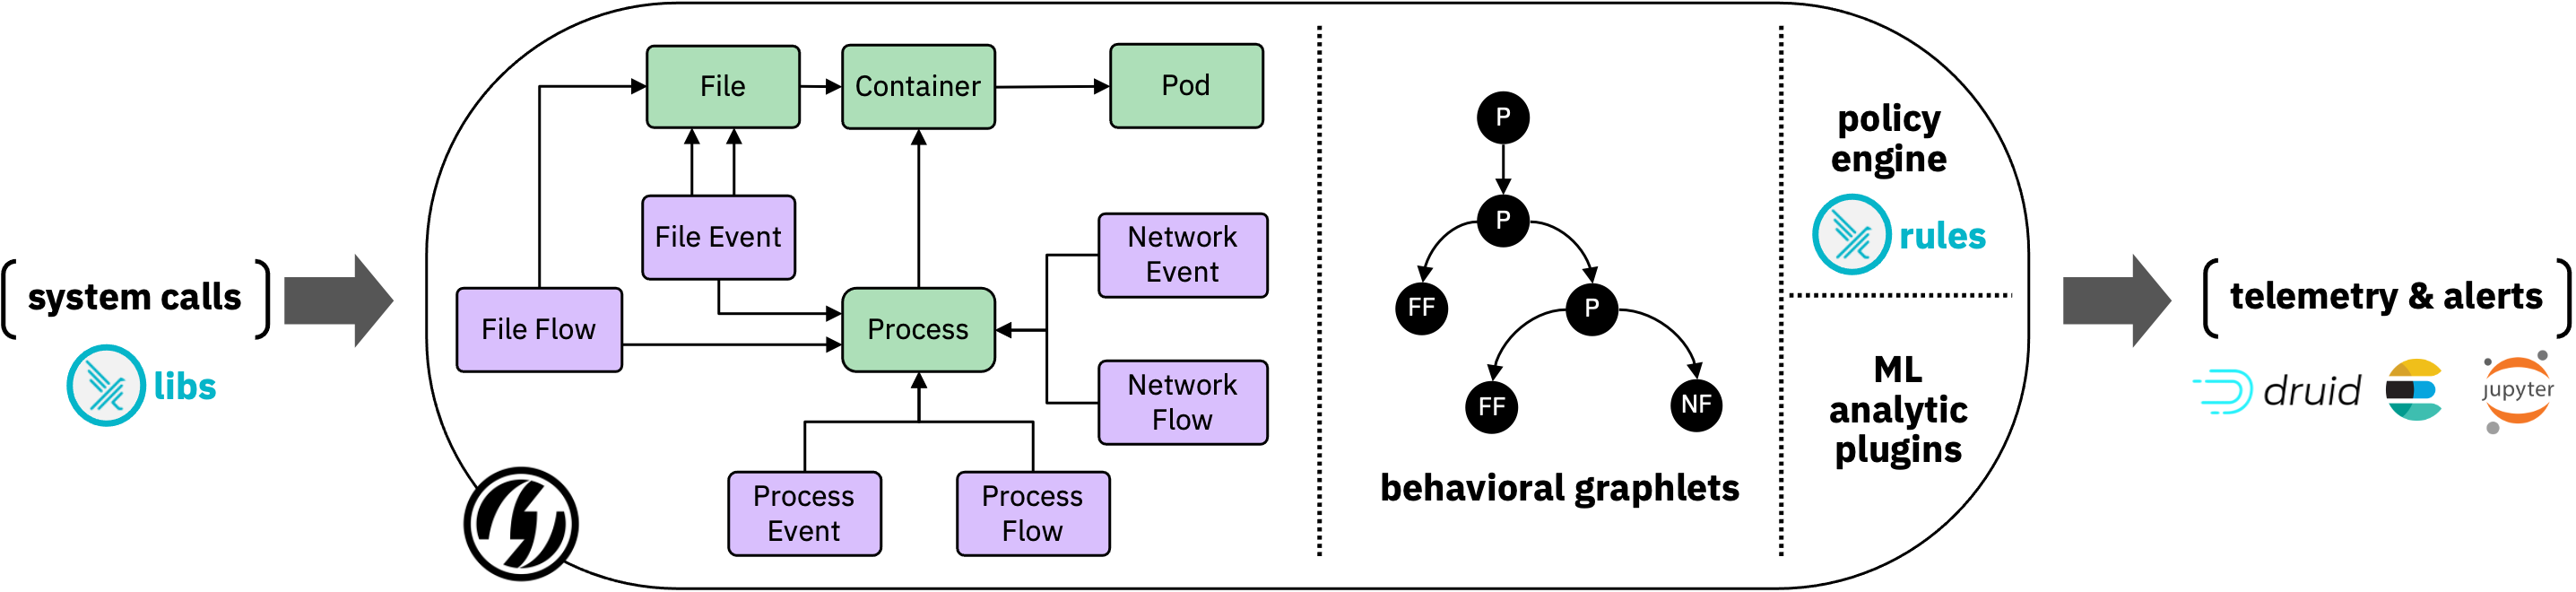
"/>
</center>

In [ ]:
# A single-process webserver
httpd = Graphlet('data/samples/httpd.sf')
httpd.view(withoid=True, peek=True, flows=True)

In [ ]:
# A graphlet of a simple client-server application
tcp = Graphlet('data/samples/tcp.sf')
tcp.view(withoid=True, peek=True, flows=True)

In [ ]:
# The underlying records associated with the graphlet
tcp.data()[cols]

## TTPs are automatically tagged to individual behaviors using policies
```
- rule: Suspicious process spawned
  desc: Suspicious behavior observed in application spawning another process
  condition: sf.type = PE and sf.opflags = EXEC 
             and sf.proc.exe != sf.pproc.exe 
             and not allowed_launchers 
             and sf.proc.name in (shell_binaries, compilers, ...)
             and not entrypoint
  action: [tag]
  priority: medium
  tags: [mitre:T1106, mitre:T1574]
```

In [ ]:
# The sysflow formatter (or sysprint) can be used to display the available record fields. 
# The fields are also documented in https://sysflow.readthedocs.io/
formatter = SFFormatter(None)
fields = formatter.getFields()
with pd.option_context('display.max_rows', None): # to show all rows
    display(pd.DataFrame(fields, columns =['Field', 'Description']))

## Hands on: Shellshock (CVE-2014–6271)
<center>
    <img style="margin:0px; padding:50px; width:70%;" src="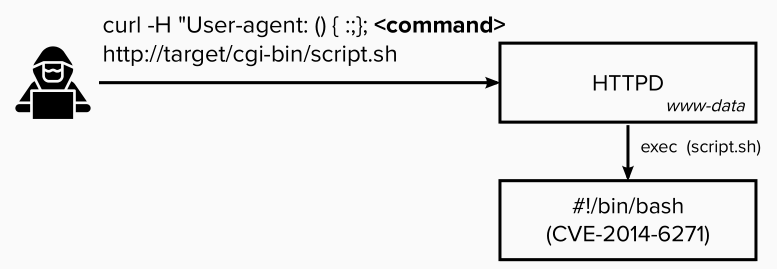
"/>
</center>

In [ ]:
# To illustrate TTP tagging, let's build a graphlet enriched by the following policy 
# for tagging MITRE ATT&CK TTPs (https://attack.mitre.org/).
apache = Graphlet('data/samples/shellshock.sf', defs=['policies/ttps.yaml'])
# Set ttps=True to highlight the nodes that have been tagged with TTPs.
apache.view(withoid=True, peek=True, flows=True, ttps=True)

In [ ]:
# Summarize the TTPs as a dataframe
apache.ttps()

In [ ]:
# Recover the records associated with the TTPs
apache_ttps = apache.data()[_cols]
apache_ttps[apache_ttps.tags != ()]

In [ ]:
# Use MITRE CTI to obtain potential mitigations for these TTPs
apache.mitigations()

In [ ]:
# Use MITRE CTI to obtain potential mitigations for these TTPs (showing associations)
apache.associatedMitigations()

In [ ]:
# Use MITRE CTI to obtain potential D3FEND (https://d3fend.mitre.org/) countermeasures for these TTPs
apache.countermeasures()

# Part 2: Attack reconstruction leveraging provenance graphs

## Hands on: Node.js (CVE-2017–5941)
_Based on BlackHat Europe'21 Arsenal demo_
<center>
    <img style="margin:0px; padding:50px; width:70%;" src="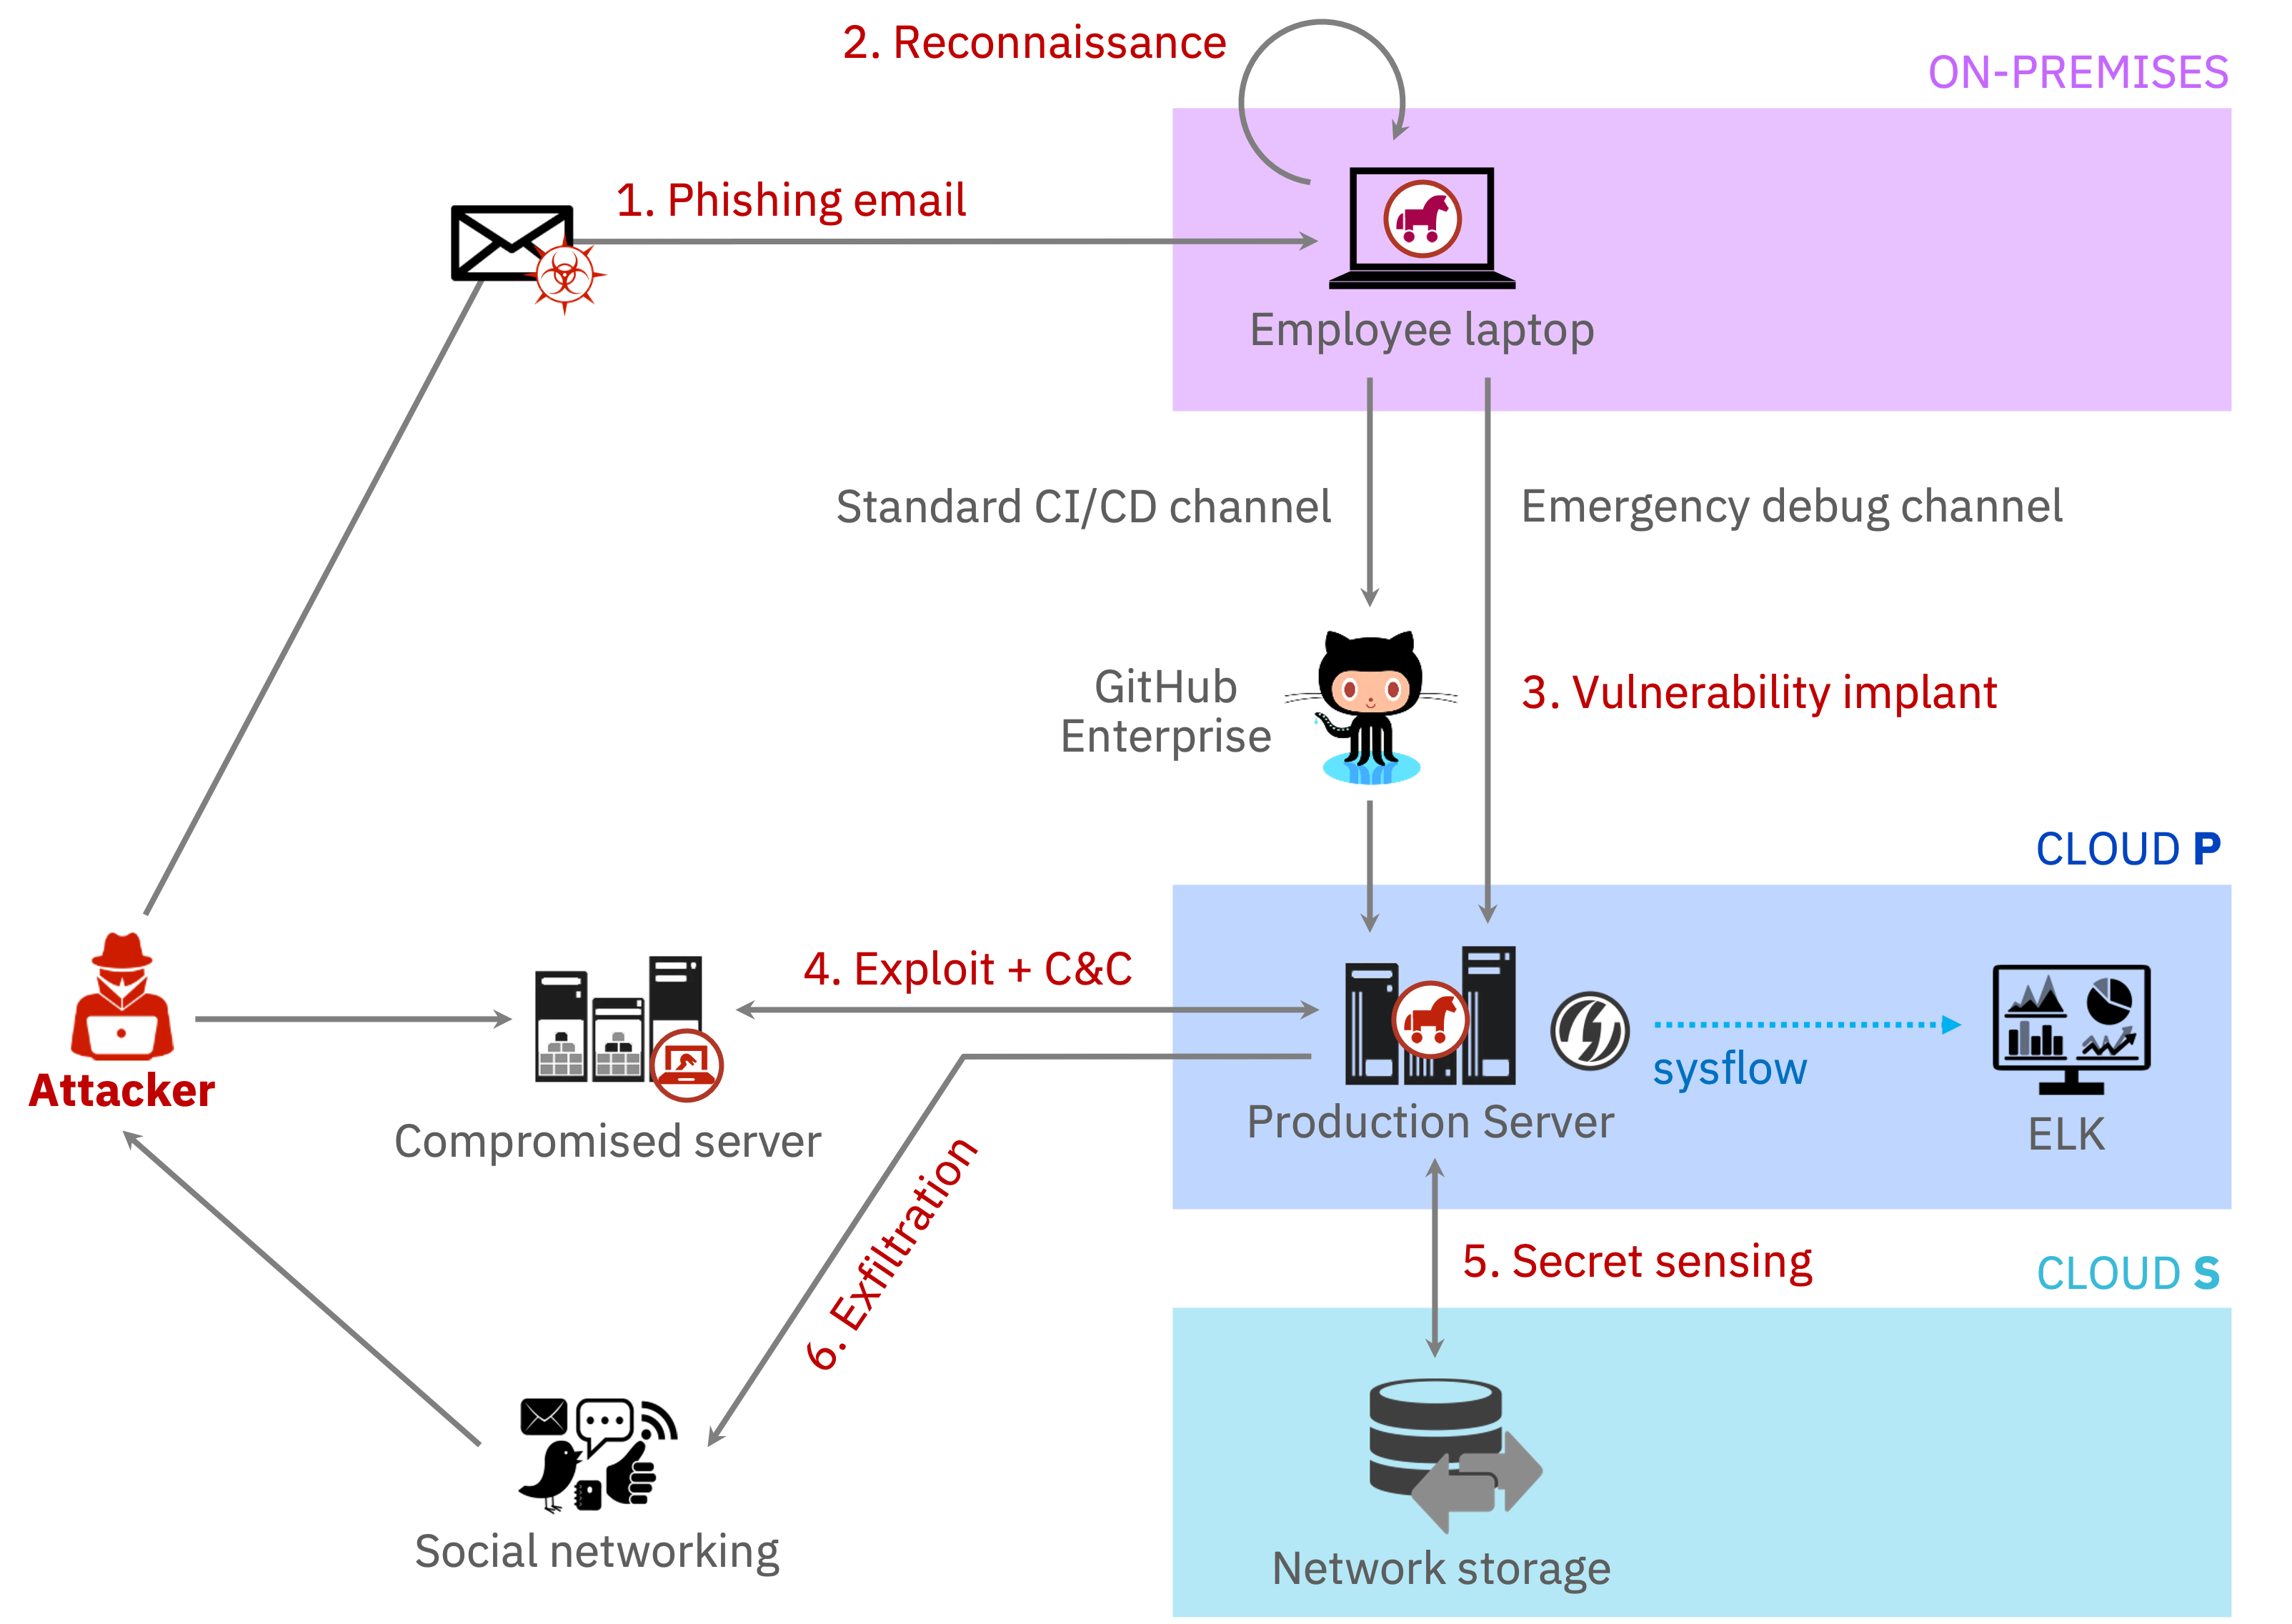
"/>
</center>

In [ ]:
# SysFlow telemetry collected on k8s server
go = Graphlet('data/bh/', defs=['policies/ttps.yaml'])

In [ ]:
# List all tagged TTPs by traversing the graphlet
go.ttps()

In [ ]:
# Obtain the sysflow record associated with the first TTP tag
ttps = go.data()[_cols]
ttps[ttps.tags != ()].head(1)

In [ ]:
# Vulnerable package implant
ioc1 = 'proc.exe = /usr/bin/scp'
g1 = Graphlet('data/bh/', ioc1, ['policies/ttps.yaml'])

In [ ]:
g1.view(withoid=True, peek=True, peeksize=10, flows=True, ttps=True)

In [ ]:
# The implant of a package.json indicates that the node process may be the attack vector
ioc2 = 'proc.aname contains node'
g2 = Graphlet('data/bh/', ioc2, ['policies/ttps.yaml'])
g2.ttps()

In [ ]:
# An ingress tool trasnfer with the node process as an ascendant is suspicious, let's investigate...
df = g2.data()
df['label'] = df['tags'].transform(str)
df[df.label.str.contains('T1105')][_cols]

In [ ]:
# Here, we look for any behaviors that are associated with the file 'tweet'.
ioc3 = 'proc.aname contains node and (proc.cmdline contains tweet or pproc.cmdline contains tweet)'
g3 = Graphlet('data/bh/', ioc3, ['policies/ttps.yaml'])
df = g3.data()
iob = df[df.tags != ()][_cols]
display(iob)

In [ ]:
# Recover the attack steps that begin with the node.js server remote exploit (pids extracted from go's nodes tagged with TTPs)
uniq = pd.unique(iob[['proc.pid','pproc.pid']].values.ravel())
pids=','.join(map(str, uniq))
ioc4 = 'proc.aname contains node and proc.pid in ('+ pids  + ')'
g4 = Graphlet('data/bh', ioc4, ['policies/ttps.yaml'])

In [ ]:
g4.view(withoid=True, peek=True, peeksize=10, flows=False, ttps=True)

In [ ]:
# The underlying records
g4.data()[cols]

In [ ]:
# the TTPs associated with the graphlet
g4.ttps()

In [ ]:
# The individual records tagged with TTPs
ttps = go.data()[_cols]
ttps[ttps.tags != ()]

In [ ]:
# Data exfiltration and C2 behavior from attacked server
ioc5 = 'proc.exe contains tweet and type in (FF, NF) and (flow.wops > 0 or flow.rops > 0)'
g5 = Graphlet('data/bh', ioc5, ['policies/ttps.yaml'])
g5.view(withoid=True, peek=True, peeksize=10, flows=True)

In [ ]:
# Ploting summary of ingress and egress traffic over time
g5.nodes[266166685698535374622837133125273067146].plot()

In [ ]:
# Find the distinct IPs associated with remote endpoints in this NF node
nf=g5.nodes[266166685698535374622837133125273067146].df()
nf['net.dip'].unique()

In [ ]:
# Exercise: find the distinct destination ports associated with this NF node

In [ ]:
# Build a Sankey graph to visualize network flows 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

containerNF =  nf.groupby(['container.name','net.sport','net.sip','net.dport', 'net.dip']).size().reset_index(name='count')
containerNF.loc[containerNF['net.sport'] > 40000, 'net.sport'] = 40001
containerNF['net.sport'] = containerNF['net.sport'].mask(containerNF['net.sport'].between(1024, 40000))
containerNF['net.sport'] = containerNF['net.sport'].replace(np.nan, '1024-40000', regex=True)
containerNF['net.sport'] = containerNF['net.sport'].replace(40001, '40001+', regex=True)
nf = px.parallel_categories(containerNF, dimensions=['container.name','net.sport', 'net.sip', 'net.dport', 'net.dip'],
                color="net.dport", color_continuous_scale=px.colors.sequential.PuBuGn
                )

In [ ]:
# Ploting the network flows for the node, with heavy traffic highlighted in green
nf.show()